In [1]:
import numpy as np
import pandas as pd
import time
import lightkurve as lk
from lightkurve import TessLightCurve, LightCurveFile
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy
%matplotlib inline

import triceratops.triceratops as tr

In [2]:
def get_aperture(pixels):
    aperture_list = []
    current_row = pixels.row
    for row in pixels.pipeline_mask:
        current_column = pixels.column
        for cell in row:
            if cell == True:
                aperture_list.append([current_column, current_row])
            current_column = current_column + 1
        current_row = current_row + 1
    return aperture_list

In [3]:
def get_triceratops_planet_candidate_probability(x):
    kic = x[1]
    ID = x[3] # a.k.a. TIC
    print(ID)
    disposition = x[4]
    planet_number = x[6]
    period = x[8]
    depth_ppm = x[10]
    depth = depth_ppm / 1000000
    
    # get target pixel file
    try:
        pixels = lk.search_targetpixelfile("TIC " + str(ID), mission="TESS").download()
        
        # get sector and aperture
        sectors = [pixels.sector]
        ap = np.array(get_aperture(pixels))
        apertures = np.array([ap])

        # create triceratops object for star
        target = tr.target(ID=ID, sectors=sectors)
        target.calc_depths(tdepth=depth, all_ap_pixels=apertures)

        # get lightcurve data and process it
        lightcurve = pixels.to_lightcurve()
        exoplanet = lightcurve.flatten().remove_outliers().fold(period=period)

        # generate and save plot
        plt.plot(exoplanet.time, exoplanet.flux)
        plt.xlabel("Time")
        plt.ylabel("Flux")
        if disposition == "FP":
            status = "FALSE POSITIVE"
        else:
            status = "CANDIDATE"
        plot_title = str(kic) + "-" + str(planet_number) + " (" + status + ")"
        plt.title(plot_title)
        plot_filename = str(kic) + "_" + str(planet_number) + ".png"
        plt.savefig(plot_filename)
        plt.close()

        # bin the data a little so it runs faster
        bins = np.linspace(exoplanet.time.min(),exoplanet.time.max(),11)
        stdvs = np.zeros(10)
        for j in range(bins.shape[0]-1):
            this_stdv = np.std(exoplanet.flux[(exoplanet.time > bins[j]) & (exoplanet.time < bins[j+1])])
            stdvs[j] = this_stdv
        sigma = np.mean(stdvs)
        lc_bins = int(exoplanet.time.shape[0]/100)
        lc = TessLightCurve(exoplanet.time, exoplanet.flux).bin(lc_bins, method='mean')

        lc = lc.remove_nans()

        # calculate the probability of a planet candidate
        target.calc_probs(time=lc.time, flux_0=lc.flux, sigma_0=sigma, P_orb=period)

        return np.round(1-target.FPP, 4)
    
    except Exception as e:
        return -1

In [4]:
df = pd.read_csv("joined_with_tess_tp_counts.csv")
df.head()

,Unnamed: 0,kic,TCE_ID,tic,disposition,not_transit,pn,n_plan,period,depth,target_pixel_files
0,0,757099,000757099-01,122785244,FP,1,1,1,0.723930,72.852405,0
1,1,892667,000892667-01,122785148,FP,1,1,1,2.262005,30.407424,0
2,2,1025986,001025986-01,122784720,FP,1,1,1,275.071787,204.701339,0
3,3,1026133,001026133-01,122784832,FP,1,1,2,1.346373,21.063829,0
4,4,1026133,001026133-02,122784832,FP,1,2,2,186.181229,278.023096,0


In [5]:
df.loc[df["target_pixel_files"] >= 1, "triceratops_probability"] = df[df["target_pixel_files"] >= 1].apply(get_triceratops_planet_candidate_probability, axis=1)

137099260
TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 137099260.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 137099260.
Calculating STP, SEB, and SEBx2P scenario probabilities for 137099260.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 137099260.
...
Calculating BTP, BEB, and BEBx2P scenario probabilities for 137099260.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 137099265.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876713955.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876713964.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876713960.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876713954.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137099256.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876713946.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876713947.
Calculating NTP, NEB, and NEBx2P sc

Calculating NTP, NEB, and NEB2xP scenario probabilities for 137099237.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876713815.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137099205.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876713875.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876713791.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876713858.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137099264.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876713790.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137099262.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876713913.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876713910.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137099307.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876713920.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 187671371

Calculating NTP, NEB, and NEBx2P scenario probabilities for 122507947.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876758968.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876758952.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876758951.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876759777.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876758969.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876758863.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122507954.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876759763.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876758970.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876758979.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876758954.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122507988.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1225080

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876955514.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137637237.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876955529.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876955532.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137637240.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137637251.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876955599.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876955593.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876955542.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137637232.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876955534.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876955827.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876955598.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18769556

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876955530.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137637292.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876955561.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876955521.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876955601.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876955528.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876955825.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876955810.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876955821.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876955596.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876955522.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137637291.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876955591.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 187695

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877251764.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877251763.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877251713.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877251760.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877251701.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877251710.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122517154.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877251767.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122517208.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122452171.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877251678.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877251769.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877251712.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877251

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948332.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948320.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120637256.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948299.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120637252.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948318.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948340.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948345.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120629888.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120629844.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715948346.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120629883.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948342.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120629873

Calculating NTP, NEB, and NEB2xP scenario probabilities for 120629855.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948330.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120637219.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120629880.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948323.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948338.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948294.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120637222.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120637226.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948306.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715948328.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948347.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120629836.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 120629837.

Calculating NTP, NEB, and NEBx2P scenario probabilities for 120637270.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948335.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948322.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120637228.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120629879.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715948292.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715948291.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948324.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120629899.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948326.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948287.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948284.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120637243.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 171594832

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 120629872.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 120629872.
Calculating STP, SEB, and SEBx2P scenario probabilities for 120629872.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 120629872.
...
Calculating BTP, BEB, and BEBx2P scenario probabilities for 120629872.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120637232.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120629867.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120637238.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 120629871.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715948315.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120637244.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120629866.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715948314.
Calculating NTP, NEB, and NEB2xP scenario probabi

Calculating NTP, NEB, and NEB2xP scenario probabilities for 122375273.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876772457.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876772488.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876772327.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876772353.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122375281.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876772348.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122375254.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122375245.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876772355.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876772479.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876772351.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122305763.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122375295

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876772340.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876772200.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876772323.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122375300.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122305826.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122375244.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122375334.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 122375208.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122305803.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122305851.
122682776
TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 122682776.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 122682776.
Calculating STP, SEB, and SEBx2P scenario probabilities for 122682776.
Calculating DTP, DEB, and DEBx2P scenario 

Calculating NTP, NEB, and NEB2xP scenario probabilities for 122682815.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877249896.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877249857.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877249833.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122682721.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122682824.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122682811.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877249929.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877249872.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877249836.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122682767.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122682732.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877249922.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877249797

Calculating NTP, NEB, and NEB2xP scenario probabilities for 137549212.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137549200.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137549131.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876993653.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137549134.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876993642.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 137549140.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876993637.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137549217.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137549130.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1876992569.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 137549235.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1876993650.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137549160.
C

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877260316.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877260267.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137095216.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877260515.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 137095204.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877260309.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877260314.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877260283.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877260478.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877260477.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877260516.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877260266.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877260285.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 187726

Calculating NTP, NEB, and NEB2xP scenario probabilities for 137095250.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877260519.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877260304.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877260310.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137095248.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877260514.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877260484.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 137095249.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877260296.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 137095202.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877260312.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137095225.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137095196.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877260293

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715902946.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715902950.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121124852.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715902941.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715902948.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715902937.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121124842.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121124827.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715902953.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715903444.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121124876.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715902949.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715903448.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 17159029

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 121124831.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 121124831.
Calculating STP, SEB, and SEBx2P scenario probabilities for 121124831.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 121124831.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 121124831.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715902945.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715903452.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121124829.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715902952.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715902951.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715903453.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121124833.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121124815.
Calculating NTP, NEB, and NEB2xP scenario probabil

Calculating NTP, NEB, and NEB2xP scenario probabilities for 121535624.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121535665.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715858630.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121535623.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715858606.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715858609.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715858611.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715858607.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121535649.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 121535632.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715858605.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715858619.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715858615.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 171585863

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714801854.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714801851.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714801659.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394179217.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714801658.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1714801667.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1714801639.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714801853.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1714801748.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394179234.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394179193.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394179179.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1714801638.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 17148016

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715903585.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121124494.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121124613.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715903570.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715903593.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121124665.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121124490.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121124653.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121124498.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121124657.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715903576.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715903581.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121124504.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715903592.


Calculating NTP, NEB, and NEB2xP scenario probabilities for 1714804102.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142366.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142359.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142269.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142376.
122142317
TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 122142317.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 122142317.
Calculating STP, SEB, and SEBx2P scenario probabilities for 122142317.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 122142317.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 122142317.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 122142321.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714804167.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714804170.
Calculating NTP, NEB, and NEB2xP scenario 

Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142326.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1714804168.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1714804164.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714804173.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714804169.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714804171.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142318.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142332.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1714804174.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714804180.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142301.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142299.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714804175.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142295

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 122142317.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 122142317.
Calculating STP, SEB, and SEBx2P scenario probabilities for 122142317.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 122142317.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 122142317.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 122142321.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714804167.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714804170.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1714804166.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714804165.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714804178.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142326.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1714804168.
Calculating NTP, NEB, and NEB2xP scenario probabi

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714804171.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142318.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142332.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1714804174.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714804180.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142301.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142299.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1714804175.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142295.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142296.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1714804172.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122142337.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 122142328.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1714802227.


Calculating NTP, NEB, and NEB2xP scenario probabilities for 122224804.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877328223.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877328392.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122304507.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877328426.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877328396.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 122304532.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877328420.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877328415.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122304497.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877328419.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877328423.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877328393.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 18773284

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877321947.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 122606503.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122606473.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877321949.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877322045.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877321232.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877321229.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877321124.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877321944.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122606507.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877321966.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122606485.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877321963.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 18773211

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877294778.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877294775.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877294751.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137151328.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877291229.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877294768.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877294769.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877294804.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877294771.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137151327.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877291233.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877291234.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137151302.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877294

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877282016.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877282013.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137550304.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877282026.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877282071.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877282001.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137550276.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877282073.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877282030.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877282069.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877282017.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137550344.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137550341.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18772820

Calculating NTP, NEB, and NEB2xP scenario probabilities for 378083816.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378083809.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877086762.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877086919.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378083850.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877086755.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877086734.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877086763.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378083840.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378083849.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378083860.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877086964.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877086962.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378083801.

Calculating NTP, NEB, and NEB2xP scenario probabilities for 378083755.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378083759.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378083783.
121214185
TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 121214185.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 121214185.
Calculating STP, SEB, and SEBx2P scenario probabilities for 121214185.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 121214185.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 121214185.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715905165.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715905166.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 121214190.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 121214182.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715905164.
Calculating NTP, NEB, and NEB2xP scenario 

Calculating NTP, NEB, and NEB2xP scenario probabilities for 122519657.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877326651.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122519638.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877326841.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122519678.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877326825.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877326846.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877326819.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122519649.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877326649.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122519637.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877326856.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 122519647.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877326871

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877298828.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877298826.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877298800.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 137152018.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877298798.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877298769.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137151994.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137152035.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877298804.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877298868.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137152008.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877298770.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877298774.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 18772987

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 120315082.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 120315082.
Calculating STP, SEB, and SEBx2P scenario probabilities for 120315082.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 120315082.


<ipython-input-3-24e5e2812e35>:55: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  target.calc_probs(time=lc.time, flux_0=lc.flux, sigma_0=sigma, P_orb=period)


Calculating BTP, BEB, and BEBx2P scenario probabilities for 120315082.


/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/funcs.py:96: RuntimeWarning: overflow encountered in power
  fluxes = 10**flux_spline(Masses)
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/marginal_likelihoods.py:1209: RuntimeWarning: invalid value encountered in true_divide
  flux_relation(masses_comp[idxs])
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/marginal_likelihoods.py:1217: RuntimeWarning: invalid value encountered in true_divide
  flux_relation(masses)


Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315085.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315078.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715999991.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315087.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315077.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715999988.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715999989.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315089.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715999990.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715999976.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315099.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 120315091.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715999997.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715999986.

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 120315082.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 120315082.
Calculating STP, SEB, and SEBx2P scenario probabilities for 120315082.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 120315082.


<ipython-input-3-24e5e2812e35>:55: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  target.calc_probs(time=lc.time, flux_0=lc.flux, sigma_0=sigma, P_orb=period)


Calculating BTP, BEB, and BEBx2P scenario probabilities for 120315082.


/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/funcs.py:96: RuntimeWarning: overflow encountered in power
  fluxes = 10**flux_spline(Masses)
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/marginal_likelihoods.py:1209: RuntimeWarning: invalid value encountered in true_divide
  flux_relation(masses_comp[idxs])


Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315085.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315078.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715999991.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315087.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315077.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715999988.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715999989.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315089.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715999990.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715999976.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315099.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 120315091.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715999997.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715999986.

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 120315082.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 120315082.
Calculating STP, SEB, and SEBx2P scenario probabilities for 120315082.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 120315082.


<ipython-input-3-24e5e2812e35>:55: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  target.calc_probs(time=lc.time, flux_0=lc.flux, sigma_0=sigma, P_orb=period)


Calculating BTP, BEB, and BEBx2P scenario probabilities for 120315082.


/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/funcs.py:96: RuntimeWarning: overflow encountered in power
  fluxes = 10**flux_spline(Masses)
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/marginal_likelihoods.py:1209: RuntimeWarning: invalid value encountered in true_divide
  flux_relation(masses_comp[idxs])
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/marginal_likelihoods.py:1217: RuntimeWarning: invalid value encountered in true_divide
  flux_relation(masses)


Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315085.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315078.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715999991.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315087.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315077.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715999988.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715999989.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315089.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715999990.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715999976.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315099.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 120315091.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715999997.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715999986.

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 120315082.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 120315082.
Calculating STP, SEB, and SEBx2P scenario probabilities for 120315082.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 120315082.


<ipython-input-3-24e5e2812e35>:55: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  target.calc_probs(time=lc.time, flux_0=lc.flux, sigma_0=sigma, P_orb=period)


Calculating BTP, BEB, and BEBx2P scenario probabilities for 120315082.


/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/funcs.py:96: RuntimeWarning: overflow encountered in power
  fluxes = 10**flux_spline(Masses)
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/marginal_likelihoods.py:1209: RuntimeWarning: invalid value encountered in true_divide
  flux_relation(masses_comp[idxs])
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/marginal_likelihoods.py:1217: RuntimeWarning: invalid value encountered in true_divide
  flux_relation(masses)


Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315085.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315078.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715999991.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315087.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315077.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715999988.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715999989.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315089.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715999990.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715999976.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120315099.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 120315091.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715999997.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715999986.

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715912926.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715912993.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 506427628.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 121327006.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715911074.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715911120.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715912987.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121326997.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 121327021.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715912970.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715912985.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121326965.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715912998.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 171591293

Calculating DTP, DEB, and DEBx2P scenario probabilities for 121122016.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 121122016.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716025367.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716025365.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121122034.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121121998.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 121122024.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716025383.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 121121996.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716025382.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716025366.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716025374.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 121122000.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 121122007.


Calculating NTP, NEB, and NEB2xP scenario probabilities for 121122032.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121215125.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121215121.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716025336.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716025386.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716025353.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716025356.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716025362.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121122061.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121121968.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716025355.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121122075.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716025372.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121215101.

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716027750.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121121686.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716026007.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121121696.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121121624.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716026008.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121121596.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121121700.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 10000672451.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121121581.
121327450
TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 121327450.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 121327450.
Calculating STP, SEB, and SEBx2P scenario probabilities for 121327450.
Calculating DTP, DEB, and DEBx2P scenari

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880363504.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880363198.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362553.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 378086346.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362878.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362548.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086341.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086288.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880362561.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086317.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086343.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880362559.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880362556.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 188036318

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880363174.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086271.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880363180.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086241.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086263.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362512.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086246.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362537.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086237.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362530.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138804574.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086244.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362516.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086252.


Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880362555.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880363217.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086275.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086268.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086261.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880362920.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 378086331.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880363505.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086328.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362873.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362544.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880363172.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086260.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362551

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362879.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880363185.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362549.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880363190.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086340.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880363497.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880362557.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086315.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362880.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880362558.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086290.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362552.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880362885.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 3780863

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362522.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880362517.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880363207.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086311.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880363528.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880363521.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086371.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362541.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362505.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 378086282.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880362538.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086248.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880362525.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18803625

Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086324.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880362545.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880363166.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880363209.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880363503.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880363203.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880363216.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086352.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086299.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086333.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086269.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880363508.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 378086280.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880363210

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 399819975.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 399819975.
Calculating STP, SEB, and SEBx2P scenario probabilities for 399819975.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 399819975.
...
Calculating BTP, BEB, and BEBx2P scenario probabilities for 399819975.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716012947.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 399819972.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 399819980.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716012948.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716012949.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716012945.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 399819970.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716012902.
Calculating NTP, NEB, and NEB2xP scenario prob

Calculating NTP, NEB, and NEB2xP scenario probabilities for 121215556.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716027266.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716027140.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121215554.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121215568.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121215589.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121215573.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121215600.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121215595.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716027142.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716027167.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716027279.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716027259.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121215551.


/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 121215583.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 121215583.
Calculating STP, SEB, and SEBx2P scenario probabilities for 121215583.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 121215583.
...
Calculating BTP, BEB, and BEBx2P scenario probabilities for 121215583.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121215574.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121215582.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121215590.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121215577.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121215572.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716027275.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716027146.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716027262.
Calculating NTP, NEB, and NEBx2P scenario probab

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716010119.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716010120.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120684593.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120684618.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716010117.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716010080.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716010085.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716010088.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716010065.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716010067.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716010087.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716010068.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716010026.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120684

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 120626764.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 120626764.
Calculating STP, SEB, and SEBx2P scenario probabilities for 120626764.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 120626764.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 120626764.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716016896.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716016847.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716016846.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716016750.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716016749.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 506415327.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120626755.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716016748.
Calculating NTP, NEB, and NEB2xP scenario probabi

Calculating NTP, NEB, and NEB2xP scenario probabilities for 121658828.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715935748.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715935774.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715935713.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715935770.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715935742.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715935793.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 121658811.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121604485.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715935736.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715935720.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715935738.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1715935769.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1715935

Calculating NTP, NEB, and NEB2xP scenario probabilities for 121866128.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121786724.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716133136.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121786771.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121786716.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716133143.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716133104.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716133094.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716133028.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121866127.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121786700.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716133108.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121786775.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121786747.


Calculating NTP, NEB, and NEB2xP scenario probabilities for 121866118.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121786877.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121866162.
137762597
TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 137762597.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 137762597.
Calculating STP, SEB, and SEBx2P scenario probabilities for 137762597.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 137762597.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 137762597.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413715.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413745.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413767.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762603.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413766.
Calculating NTP, NEB, and NEB2xP scenario

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413752.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413701.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762646.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413794.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762632.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762537.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413724.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413722.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413763.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413792.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413501.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762608.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413705.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18774135

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 137762597.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 137762597.
Calculating STP, SEB, and SEBx2P scenario probabilities for 137762597.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 137762597.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 137762597.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413715.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413745.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413767.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762603.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413766.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413717.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762596.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762602.
Calculating NTP, NEB, and NEB2xP scenario probabil

Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762632.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762537.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413724.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413722.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413763.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413792.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413501.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762608.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413705.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413502.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762620.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413499.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413532.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18774134

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/funcs.py:96: RuntimeWarning: overflow encountered in power
  fluxes = 10**flux_spline(Masses)
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/marginal_likelihoods.py:1209: RuntimeWarning: invalid value encountered in true_divide
  flux_relation(masses_comp[idxs])
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/marginal_likelihoods.py:1217: RuntimeWarning: invalid value encountered in true_divide
  flux_relation(masses)


Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413715.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413745.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413767.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762603.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413766.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413717.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762596.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762602.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762585.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413731.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413749.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413771.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413735.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 50690548

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413792.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413501.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762608.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413705.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413502.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762620.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413499.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413532.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413495.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762590.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413708.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762658.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413528.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18774135

Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762546.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413756.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413796.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413758.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413793.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762544.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413526.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762542.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413776.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762641.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413725.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413754.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413500.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 13776256

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 137762597.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 137762597.
Calculating STP, SEB, and SEBx2P scenario probabilities for 137762597.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 137762597.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 137762597.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413715.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413745.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413767.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762603.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413766.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413717.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762596.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762602.
Calculating NTP, NEB, and NEB2xP scenario probabil

Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762632.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762537.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413724.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413722.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413763.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413792.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413501.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762608.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413705.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413502.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762620.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413499.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413532.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18774134

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/funcs.py:96: RuntimeWarning: overflow encountered in power
  fluxes = 10**flux_spline(Masses)
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/marginal_likelihoods.py:1209: RuntimeWarning: invalid value encountered in true_divide
  flux_relation(masses_comp[idxs])
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/triceratops/marginal_likelihoods.py:1217: RuntimeWarning: invalid value encountered in true_divide
  flux_relation(masses)


Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413715.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413745.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413767.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762603.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413766.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413717.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762596.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762602.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762585.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413731.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413749.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413771.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413735.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 50690548

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413792.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413501.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762608.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413705.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413502.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762620.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413499.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413532.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413495.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762590.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413708.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762658.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413528.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18774135

Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762546.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413756.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413796.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413758.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413793.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762544.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413526.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762542.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413776.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762641.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413725.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413754.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413500.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 13776256

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413721.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762614.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413768.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413744.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413769.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413747.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413726.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413746.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 137762625.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762628.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 137762627.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413750.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413728.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18774137

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413749.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413771.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413735.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 506905485.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413732.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762576.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762609.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762613.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413733.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762577.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413718.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413711.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762580.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 137762610.

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413796.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413758.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413793.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762544.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413526.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762542.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413776.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762641.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413725.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1877413754.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413500.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137762567.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1877413790.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18774137

Calculating NTP, NEB, and NEB2xP scenario probabilities for 138971580.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880377411.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880377374.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880377412.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880377364.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880377386.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880377382.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880377354.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880377394.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 138971560.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880377363.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880377428.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880378692.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 188037

121598562
TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 121598562.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 121598562.
Calculating STP, SEB, and SEBx2P scenario probabilities for 121598562.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 121598562.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 121598562.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716183218.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 121598549.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716183217.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716183219.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121598565.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716183220.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716183222.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716183204.
Calculating NTP, NEB, and NEB2xP scenar

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 169081296.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 169081296.
Calculating STP, SEB, and SEBx2P scenario probabilities for 169081296.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 169081296.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 169081296.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879880429.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879880282.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879880421.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879880425.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879880422.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 169081304.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879880424.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 169081288.
Calculating NTP, NEB, and NEB2xP scenario probabi

Calculating NTP, NEB, and NEB2xP scenario probabilities for 169081239.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879880431.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 169081277.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 169081356.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879880309.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879880299.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879880296.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879880266.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879880297.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 169081285.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879879888.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879880119.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 10000712437.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879880

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Insufficient information to validate 120317590. Please provide an estimate for stellar mass, radius, and Teff.
120317590


/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Insufficient information to validate 120317590. Please provide an estimate for stellar mass, radius, and Teff.
169461816


/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 169461816.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 169461816.
Calculating STP, SEB, and SEBx2P scenario probabilities for 169461816.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 169461816.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 169461816.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 169461804.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879946763.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879946765.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879946772.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879946767.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879946764.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 169461803.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879946766.
Calculating NTP, NEB, and NEB2xP scenario probabi

Calculating NTP, NEB, and NEB2xP scenario probabilities for 169461879.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879946779.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879946801.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879946796.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879946755.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879946793.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879946812.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879946723.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879946715.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 169461847.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 169461792.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879946737.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879946720.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879946

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716193964.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716193719.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 121731802.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121731851.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716193880.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716193878.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716193971.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121731818.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716193746.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121731804.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716193877.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716194013.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716193972.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 17161940

Calculating NTP, NEB, and NEB2xP scenario probabilities for 121731803.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121731801.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121731836.
121731834
TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 121731834.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 121731834.
Calculating STP, SEB, and SEBx2P scenario probabilities for 121731834.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 121731834.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 121731834.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716193758.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121731831.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716194004.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716194006.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716194010.
Calculating NTP, NEB, and NEB2xP scenario

Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422061.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422035.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716425254.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422067.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422054.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716425236.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716425235.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422083.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422073.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422031.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422088.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422044.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422030.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422090.
Cal

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 120422055.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 120422055.
Calculating STP, SEB, and SEBx2P scenario probabilities for 120422055.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 120422055.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 120422055.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422057.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716425210.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422058.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716425238.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716425212.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716425239.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422072.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716425205.
Calculating NTP, NEB, and NEBx2P scenario probabil

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 120422055.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 120422055.
Calculating STP, SEB, and SEBx2P scenario probabilities for 120422055.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 120422055.
...
...
Calculating BTP, BEB, and BEBx2P scenario probabilities for 120422055.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422057.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716425210.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422058.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716425238.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716425212.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716425239.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120422072.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716425205.
Calculating NTP, NEB, and NEBx2P scenario 

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880801374.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138297296.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880801434.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880801421.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880801470.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138297315.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880801536.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880801438.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138297278.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880801436.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880801437.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138297288.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138297228.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138297314

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882299928.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882299970.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882299922.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882299976.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137341388.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 137341335.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 506891979.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882299876.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137341392.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 137341386.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 10000685365.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882299921.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 137341393.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 188230011

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 120420369.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 120420369.
Calculating STP, SEB, and SEBx2P scenario probabilities for 120420369.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 120420369.
...


<ipython-input-3-24e5e2812e35>:55: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  target.calc_probs(time=lc.time, flux_0=lc.flux, sigma_0=sigma, P_orb=period)


Calculating BTP, BEB, and BEBx2P scenario probabilities for 120420369.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716448033.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716448034.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120420362.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716448035.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716448038.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716448036.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716448032.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120420371.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 120420384.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716448039.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716448042.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716448041.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 12042038

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716098804.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716097155.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716098803.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121016543.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716098728.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716098811.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716097161.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716097156.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716098829.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121016580.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121016561.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716097160.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 121016615.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 17160987

TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 137341551.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 137341551.
Calculating STP, SEB, and SEBx2P scenario probabilities for 137341551.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 137341551.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 137341551.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137341547.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882301662.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882301645.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882301646.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882301665.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882301671.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882301659.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882301647.
Calculating NTP, NEB, and NEBx2P scenario probab

TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 137341551.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 137341551.
Calculating STP, SEB, and SEBx2P scenario probabilities for 137341551.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 137341551.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 137341551.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 137341547.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882301662.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882301645.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882301646.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882301665.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882301671.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882301659.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882301647.
Calculating NTP, NEB, and NEBx2P scenario probab

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Insufficient information to validate 169819162. Please provide an estimate for stellar mass, radius, and Teff.
170246384


/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 170246384.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 170246384.
Calculating STP, SEB, and SEBx2P scenario probabilities for 170246384.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 170246384.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 170246384.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 170246379.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879961415.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962485.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879961412.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879962498.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962484.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246349.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879961422.
Calculating NTP, NEB, and NEB2xP scenario probabi

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879962520.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 170246480.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962443.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246373.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962511.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879962507.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879961583.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 170246499.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246244.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962652.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879961589.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246406.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246343.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879961367

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 170246384.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 170246384.
Calculating STP, SEB, and SEBx2P scenario probabilities for 170246384.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 170246384.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 170246384.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 170246379.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879961415.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962485.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879961412.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879962498.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962484.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246349.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879961422.
Calculating NTP, NEB, and NEB2xP scenario probabi

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879962520.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 170246480.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962443.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246373.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962511.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879962507.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879961583.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 170246499.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246244.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962652.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879961589.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246406.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246343.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879961367

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 170246384.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 170246384.
Calculating STP, SEB, and SEBx2P scenario probabilities for 170246384.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 170246384.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 170246384.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 170246379.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879961415.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962485.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879961412.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879962498.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962484.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246349.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879961422.
Calculating NTP, NEB, and NEB2xP scenario probabi

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879962520.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 170246480.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962443.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246373.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962511.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879962507.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879961583.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 170246499.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246244.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962652.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879961589.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246406.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246343.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879961367

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 170246384.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 170246384.
Calculating STP, SEB, and SEBx2P scenario probabilities for 170246384.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 170246384.
...
Calculating BTP, BEB, and BEBx2P scenario probabilities for 170246384.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 170246379.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879961415.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962485.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879961412.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879962498.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962484.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246349.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879961422.
Calculating NTP, NEB, and NEB2xP scenario pro

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879962520.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 170246480.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962443.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246373.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962511.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879962507.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879961583.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 170246499.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246244.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879962652.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1879961589.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246406.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 170246343.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1879961367

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880077265.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 508754037.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880077258.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 171971690.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880077334.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880077310.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880077276.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880077757.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 171971678.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880077338.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880077704.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880077774.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 171971578.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 18800773

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880078222.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 171971563.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880077708.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880078185.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 171971726.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 171971722.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880078196.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880078189.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880078182.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880077279.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880078227.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880077802.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 171971537.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 17197162

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177710.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172632.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172571.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172554.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177782.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177785.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172570.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177779.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172609.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177801.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172616.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177787.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172552.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172576.


Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172570.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177779.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172609.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177801.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172616.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177787.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172552.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172576.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172602.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172578.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172611.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172549.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177847.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172645.
Ca

Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172552.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172576.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172602.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172578.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172611.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172549.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177847.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172645.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716177805.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177707.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172544.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716177804.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172582.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172642.
Ca

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177847.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172645.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716177805.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177707.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172544.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716177804.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172582.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172642.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172653.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172655.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716177701.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172583.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177803.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177802.

Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172582.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172642.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172653.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172655.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716177701.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172583.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177803.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716177802.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172588.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172660.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172594.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172580.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172656.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 394172672.
138

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 138221966.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 138221966.
Calculating STP, SEB, and SEBx2P scenario probabilities for 138221966.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 138221966.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 138221966.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880869012.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880868989.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138221955.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138221953.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880868994.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880868990.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880868987.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880868981.
Calculating NTP, NEB, and NEBx2P scenario probabi

Calculating NTP, NEB, and NEB2xP scenario probabilities for 138221949.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880869704.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138222021.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880868888.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138222028.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880868910.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138222033.
138431008


/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 138431008.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 138431008.
Calculating STP, SEB, and SEBx2P scenario probabilities for 138431008.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 138431008.
...
Calculating BTP, BEB, and BEBx2P scenario probabilities for 138431008.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880811752.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880811743.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138431011.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880811754.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880811756.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138430993.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880811751.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880811759.
Calculating NTP, NEB, and NEBx2P scenario pro

Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880811694.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138430950.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138430948.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138430953.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138431053.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138430985.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138430977.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138431070.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138430975.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 138431010.
138638780
138638780
138429650
137408962
137408962
138430438
138430438
138430438
271052158
271052158
164530781
164530781
63370066
164647385
164647385
164729491
274031528
159573299
159573299
274031155
274031155
268289462
123408988
164674992
158721695
164461124
164461124
164461124
164461124


/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 164884235.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 164884235.
Calculating STP, SEB, and SEBx2P scenario probabilities for 164884235.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 164884235.


<ipython-input-3-24e5e2812e35>:55: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  target.calc_probs(time=lc.time, flux_0=lc.flux, sigma_0=sigma, P_orb=period)


Calculating BTP, BEB, and BEBx2P scenario probabilities for 164884235.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 164884237.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716632529.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716632197.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716632530.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716632523.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716632203.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 164884242.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716632522.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716632205.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716632520.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1716632531.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1716632521.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1648842

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882472360.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 159719825.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882472625.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882472624.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882472239.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 159719770.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882472245.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882472636.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882472495.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 159719799.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882472486.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 159719768.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 159719844.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 188247241

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882472246.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882472496.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882472359.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882472490.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882472413.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 159719804.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 159719774.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 159719785.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882472491.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882472360.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 159719825.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882472625.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882472624.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 18824722

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 269121699.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 269121699.
Calculating STP, SEB, and SEBx2P scenario probabilities for 269121699.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 269121699.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 269121699.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296585.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296584.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296583.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296582.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296594.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296586.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269121710.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296593.
Calculating NTP, NEB, and NEBx2P scenario probab

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296058.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296611.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263854.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263787.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296563.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 269263769.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880295940.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296564.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880296577.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296556.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880295968.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263891.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296571.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18802959

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 269121699.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 269121699.
Calculating STP, SEB, and SEBx2P scenario probabilities for 269121699.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 269121699.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 269121699.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296585.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296584.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296583.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296582.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296594.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296586.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269121710.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296593.
Calculating NTP, NEB, and NEBx2P scenario probab

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296058.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296611.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263854.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263787.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296563.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 269263769.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880295940.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296564.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880296577.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296556.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880295968.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263891.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296571.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18802959

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 269121699.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 269121699.
Calculating STP, SEB, and SEBx2P scenario probabilities for 269121699.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 269121699.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 269121699.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296585.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296584.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296583.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296582.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296594.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296586.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269121710.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296593.
Calculating NTP, NEB, and NEBx2P scenario probab

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296058.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296611.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263854.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263787.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296563.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 269263769.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880295940.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296564.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880296577.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296556.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880295968.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263891.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296571.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18802959

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 269121699.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 269121699.
Calculating STP, SEB, and SEBx2P scenario probabilities for 269121699.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 269121699.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 269121699.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296585.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296584.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296583.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296582.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296594.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296586.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269121710.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296593.
Calculating NTP, NEB, and NEBx2P scenario probab

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296058.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296611.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263854.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263787.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296563.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 269263769.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880295940.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296564.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880296577.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296556.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880295968.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263891.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296571.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18802959

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 269121699.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 269121699.
Calculating STP, SEB, and SEBx2P scenario probabilities for 269121699.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 269121699.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 269121699.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296585.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296584.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296583.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296582.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296594.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296586.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269121710.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296593.
Calculating NTP, NEB, and NEBx2P scenario probab

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296058.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296611.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263854.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263787.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296563.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 269263769.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880295940.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296564.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880296577.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296556.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880295968.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263891.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296571.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18802959

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 269121699.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 269121699.
Calculating STP, SEB, and SEBx2P scenario probabilities for 269121699.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 269121699.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 269121699.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296585.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296584.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296583.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296582.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296594.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296586.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269121710.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296593.
Calculating NTP, NEB, and NEBx2P scenario probab

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296058.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296611.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263854.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263787.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296563.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 269263769.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880295940.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296564.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880296577.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296556.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880295968.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263891.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296571.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18802959

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 269121699.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 269121699.
Calculating STP, SEB, and SEBx2P scenario probabilities for 269121699.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 269121699.
...
Calculating BTP, BEB, and BEBx2P scenario probabilities for 269121699.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296585.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296584.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296583.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296582.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296594.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296586.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269121710.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296593.
Calculating NTP, NEB, and NEBx2P scenario pr

Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296058.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296611.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263854.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263787.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296563.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 269263769.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880295940.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296564.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880296577.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296556.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880295968.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263891.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296571.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 18802959

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 269263577.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 269263577.
Calculating STP, SEB, and SEBx2P scenario probabilities for 269263577.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 269263577.
...
Calculating BTP, BEB, and BEBx2P scenario probabilities for 269263577.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296113.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296111.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296108.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296114.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263580.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880296103.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296109.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296100.
Calculating NTP, NEB, and NEB2xP scenario pr

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 269263577.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 269263577.
Calculating STP, SEB, and SEBx2P scenario probabilities for 269263577.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 269263577.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 269263577.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296113.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296111.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296108.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296114.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263580.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880296103.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296109.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296100.
Calculating NTP, NEB, and NEB2xP scenario probab

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 269263577.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 269263577.
Calculating STP, SEB, and SEBx2P scenario probabilities for 269263577.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 269263577.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 269263577.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296113.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296111.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296108.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296114.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 269263580.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1880296103.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296109.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1880296100.
Calculating NTP, NEB, and NEB2xP scenario probab

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 63125816.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 63125816.
Calculating STP, SEB, and SEBx2P scenario probabilities for 63125816.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 63125816.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 63125816.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882441212.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882441211.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 63125824.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882441208.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 63125808.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882441207.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882441210.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 63125804.
Calculating NTP, NEB, and NEB2xP scenario probabilities fo

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 63125816.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 63125816.
Calculating STP, SEB, and SEBx2P scenario probabilities for 63125816.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 63125816.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 63125816.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882441212.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882441211.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 63125824.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882441208.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 63125808.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882441207.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882441210.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 63125804.
Calculating NTP, NEB, and NEB2xP scenario probabilities fo

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 63125816.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 63125816.
Calculating STP, SEB, and SEBx2P scenario probabilities for 63125816.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 63125816.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 63125816.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882441212.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882441211.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 63125824.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882441208.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 63125808.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882441207.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882441210.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 63125804.
Calculating NTP, NEB, and NEB2xP scenario probabilities fo

/Users/deanwang/anaconda3/envs/triceratops/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


TRILEGAL form submitted.
Calculating TP, EB, and EBx2P scenario probabilities for 63125816.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 63125816.
Calculating STP, SEB, and SEBx2P scenario probabilities for 63125816.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 63125816.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 63125816.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882441212.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882441211.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 63125824.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882441208.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 63125808.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 1882441207.
Calculating NTP, NEB, and NEBx2P scenario probabilities for 1882441210.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 63125804.
Calculating NTP, NEB, and NEB2xP scenario probabilities fo

In [6]:
df.head()

,Unnamed: 0,kic,TCE_ID,tic,disposition,not_transit,pn,n_plan,period,depth,target_pixel_files,triceratops_probability
0,0,757099,000757099-01,122785244,FP,1,1,1,0.723930,72.852405,0,NaN
1,1,892667,000892667-01,122785148,FP,1,1,1,2.262005,30.407424,0,NaN
2,2,1025986,001025986-01,122784720,FP,1,1,1,275.071787,204.701339,0,NaN
3,3,1026133,001026133-01,122784832,FP,1,1,2,1.346373,21.063829,0,NaN
4,4,1026133,001026133-02,122784832,FP,1,2,2,186.181229,278.023096,0,NaN


<AxesSubplot:>

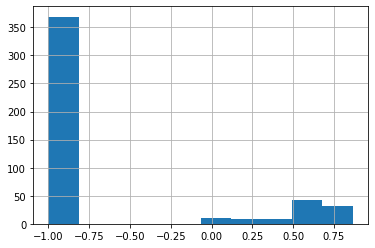

In [8]:
df["triceratops_probability"].hist()

In [11]:
df[df["triceratops_probability"] == -1]["kic"].count()

369

In [ ]:
df.loc[df["triceratops_probability"] == -1, "triceratops_probability"] = df[df["triceratops_probability"] == -1].apply(get_triceratops_planet_candidate_probability, axis=1)

<AxesSubplot:>

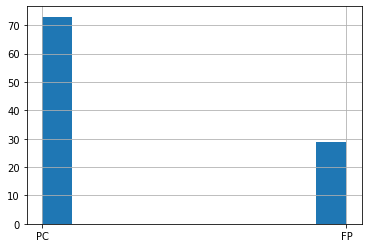

In [15]:
df.loc[df["triceratops_probability"] >= 0.5, "triceratops_disposition"] = "PC"
df.loc[(df["triceratops_probability"] < 0.5) & (df["triceratops_probability"] >= 0), "triceratops_disposition"] = "FP"

In [21]:
df = df.drop(['Unnamed: 0'], axis=1)

In [22]:
df.to_csv("triceratops_classified_test.csv", index=False, header=False)